In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
a = math.atan2(2,1)
print(a)

1.1071487177940904


In [3]:
print(np.pi)

3.141592653589793


In [4]:
data1 = pd.read_csv('data/NGSIM_Peachtree_Vehicle_Trajectories.csv')
data2 = pd.read_csv('data/NGSIM__Lankershim_Vehicle_Trajectories.csv')
data3  = pd.read_csv('data/Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv')

data = pd.concat([data1,data3],axis=0)

data = pd.concat([data,pd.get_dummies(data['Location'],prefix='Location'),
                  pd.get_dummies(data['v_Class'],prefix='v_Class'),
                  pd.get_dummies(data['Direction'],prefix='Direction'),
                  pd.get_dummies(data['Movement'],prefix='Movement'),
                 ],axis=1)#把location列归一化
data = data.drop(['Location','v_Class','Lane_ID','O_Zone','D_Zone',
                  'Int_ID','Section_ID','Direction','Movement'],
                 axis=1)

for i in range(len(data['Preceding'].values)):
    if data['Preceding'].values[i]>0:
        data['Preceding'].values[i] = 1

for i in range(len(data['Following'].values)):
    if data['Following'].values[i]>0:
        data['Following'].values[i] = 1
        
data['Yaw_Angle'] = 0.
for i in range(len(data['Global_Y'].values)-1):
    yaw_angle = math.atan2(data['Global_Y'].values[i+1] - data['Global_Y'].values[i],
                           data['Global_X'].values[i+1] - data['Global_X'].values[i])*180/np.pi
    data['Yaw_Angle'].values[i] = yaw_angle
import numpy as np
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm
print('begin...')
data1=normalize(data)
#data1['Yaw_Angle'] = data['Yaw_Angle']
data1.to_csv('处理数据/标准化数据.csv')
print('end')


KeyboardInterrupt: 

In [4]:
data1 = pd.read_csv('data/NGSIM_Peachtree_Vehicle_Trajectories.csv')
#data2 = pd.read_csv('data/NGSIM__Lankershim_Vehicle_Trajectories.csv')
data3  = pd.read_csv('data/Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv')

data_ = pd.concat([data1,data3],axis=0)
quant_features = ['Local_X','Local_Y','Global_X','Global_Y']
scaled_features = {}
print('start..')
for each in quant_features:
    mean, std = data_[each].mean(), data_[each].max()-data_[each].min()
    scaled_features[each] = [mean, std]
    data_.loc[:, each] = (data_[each] - mean)/std
mean_x, std_x = scaled_features['Local_X']
mean_y, std_y = scaled_features['Local_Y']
print(mean_x, std_x)
print(mean_y, std_y)

start..
0.2436986727949202 486.509
927.7015568869493 2113.03


In [5]:

#分别得到坐标值和feature
#print(set(data['Yaw_Angle'].values),len(data['Yaw_Angle'].values))
data = pd.read_csv('处理数据/标准化数据.csv')
position_global = np.array(data[['Global_X','Global_Y']])
position_local =  np.array(data[['Local_X','Local_Y']])
#vehicle_feature = np.array(data.drop(['Vehicle_ID','Frame_ID','Total_Frames','Global_Time','Global_X','Global_Y','Location_peachtree'],
        #                            axis=1))
vehicle_feature = np.array(data[['Local_X','Local_Y',
                                 'v_length','v_Width','v_Class_1','v_Class_2',
                                 'v_Class_3','v_Vel','v_Acc','Preceding','Following',
                                 'Direction_1',
                                 'Direction_2','Direction_3','Direction_4','Movement_1','Movement_2','Movement_3'
                              ]])

#vehicle_label = np.zeros_like(position_local)
#vehicle_label[:-1],vehicle_label[-1] = position_local[1:],position_local[0]
vehicle_label = position_local
vehicle_feature = vehicle_feature.astype(np.float32)
vehicle_label = vehicle_label.astype(np.float32)

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
train_x,val_test_x = vehicle_feature[:int(len(vehicle_feature)*split_frac)],vehicle_feature[int(len(vehicle_feature)*split_frac):]
val_x,test_x = val_test_x[:len(val_test_x)//2],val_test_x[len(val_test_x)//2:]

train_y,val_test_y = vehicle_label[:int(len(vehicle_label)*split_frac)],vehicle_label[int(len(vehicle_label)*split_frac):]
val_y,test_y = val_test_y[:len(val_test_y)//2],val_test_y[len(val_test_y)//2:]


import torch
from torch.utils.data import TensorDataset, DataLoader
 
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#iters = iter(train_loader)
#x, y = next(iters)
#print(x,y)
#得到车辆数
vehicle_id = np.array(data['Vehicle_ID'])
print('总采样数为:',len(vehicle_feature))
print('总车辆数为:',len(np.unique(vehicle_id)))

总采样数为: 1676606
总车辆数为: 1545


In [ ]:
x,y = next(iter(train_loader))
y = y.cpu().detach().numpy().tolist() 
x = x.cpu().detach().numpy().tolist() 
plt.scatter([s[0] for s in y[0:30]],[s[1] for s in y[0:30]],color= 'red',label = 'globl_position')
plt.scatter([s[0] for s in x[0:30]],[s[1] for s in x[0:30]],color= 'b',label = 'globl_position')

Global location trajectory

(2940, 2)


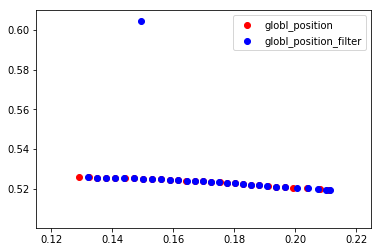

(226, 2)


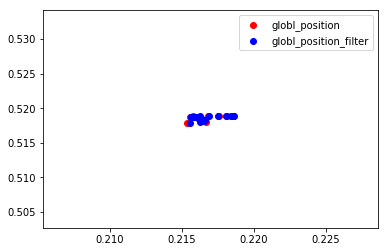

(310, 2)


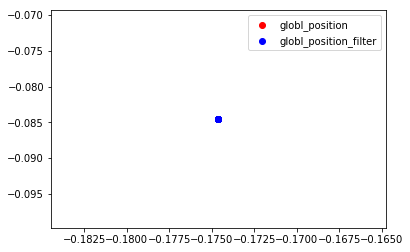

(31, 2)


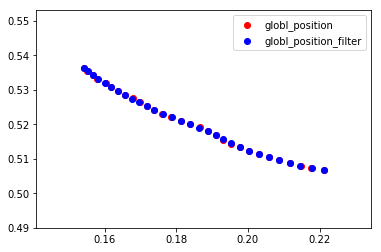

(44, 2)


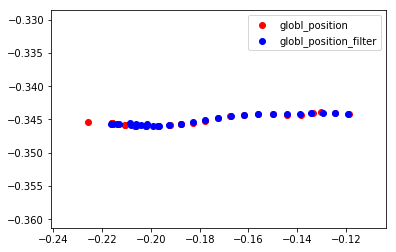

(18, 2)


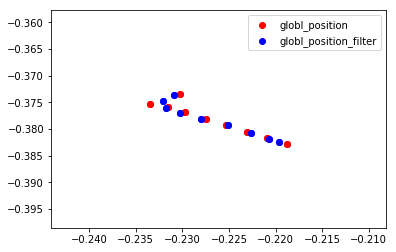

(1352, 2)


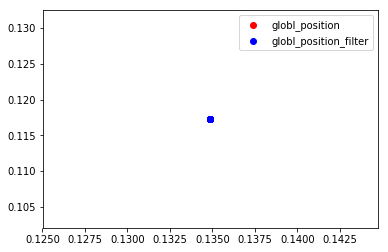

(1352, 2)


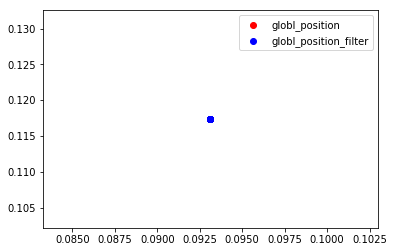

(3930, 2)


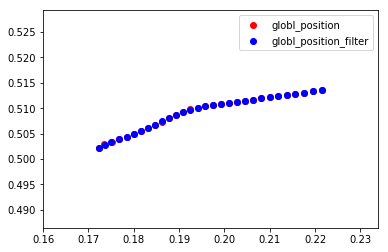

(261, 2)


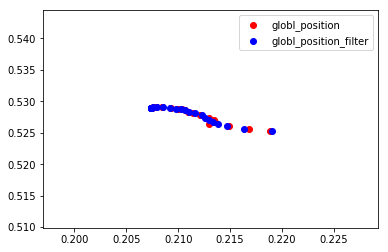

In [20]:
from scipy.signal import savgol_filter
i = 0
vehicle_locations = []
for id in np.unique(vehicle_id):
    i = i +1
    vehicle_location = position_global[np.argwhere(vehicle_id==id)].squeeze()
    vehicle_locations.append(len(vehicle_location))
    print(vehicle_location.shape)
    if len(vehicle_location):
        location_filter = savgol_filter(vehicle_location,9,3,axis=0)
    plt.scatter([s[0] for s in vehicle_location[0:30]],[s[1] for s in vehicle_location[0:30]],color= 'red',label = 'globl_position')
    plt.scatter([s[0] for s in location_filter[0:30]],[s[1] for s in location_filter[0:30]],color= 'b',label = 'globl_position_filter')
    #print([s[0][0] for s in vehicle_location[0:30]],[s[0][1] for s in vehicle_location[0:30]])
    #plt.plot([s[0] for s in position_local[0:30]],[s[1]for s in position_local[0:30]],color = 'blue',label = 'local_position')
    plt.legend()
    plt.show()
    if i == 10:
        break

#plt.savefig('local_postion.png')

Local location trjectory 

In [ ]:
i = 0
vehicle_locations = []
for id in np.unique(vehicle_id):
    i = i +1
    vehicle_location = position_local[np.argwhere(vehicle_id==id)]
    vehicle_locations.append(len(vehicle_location))
    plt.scatter([s[0][0] for s in vehicle_location[0:30]],[s[0][1] for s in vehicle_location[0:30]],color= 'red',label = 'local_position')
    #print([s[0][0] for s in vehicle_location[0:30]],[s[0][1] for s in vehicle_location[0:30]])
    #plt.plot([s[0] for s in position_local[0:30]],[s[1]for s in position_local[0:30]],color = 'blue',label = 'local_position')
    plt.legend()
    plt.show()
    if i == 10:
        break

#plt.savefig('local_postion.png')

In [ ]:
print(min(vehicle_locations),max(vehicle_locations))
print(vehicle_locations)

In [15]:
import torch
from torch import nn
def linear_batch_norm(input_size, output_size, batch_norm=True):
    layer = []
    linear = nn.Linear(input_size, output_size)
    layer.append(linear)
    if batch_norm:
        batch_norm_ = nn.BatchNorm1d(output_size)
        layer.append(batch_norm_)

    return nn.Sequential(*layer)
class trajectory_predict(nn.Module):
    def __init__(self,input_size=16,conv_dim=32,out_size=2):
        super(trajectory_predict,self).__init__()
        self.conv_dim = conv_dim
        self.conv_dim = input_size
        self.fc1 = linear_batch_norm(input_size,conv_dim*4)
        
        self.fc2 = linear_batch_norm(conv_dim*4,conv_dim*6)
        
        self.fc3 = linear_batch_norm(conv_dim*6,conv_dim*8)
        
        self.fc4 = linear_batch_norm(conv_dim*8,conv_dim*4)
        
        self.fc5 = linear_batch_norm(conv_dim*4,conv_dim*2)
        self.fc6 = linear_batch_norm(conv_dim*2,conv_dim*2)
        self.fc7 = linear_batch_norm(conv_dim*2,conv_dim)
        self.fc8 = linear_batch_norm(conv_dim,conv_dim*4)
       
        self.fc9 = linear_batch_norm(conv_dim*4,conv_dim*8)
        self.fc10 = linear_batch_norm(conv_dim*8,conv_dim*4)
        """
        self.fc11 = linear_batch_norm(conv_dim*4,conv_dim*4)
        self.fc12 = linear_batch_norm(conv_dim*4,conv_dim*3)
        self.fc13 = linear_batch_norm(conv_dim*3,conv_dim*2)
        self.fc14 = linear_batch_norm(conv_dim*2,conv_dim*4)
        self.fc15 = linear_batch_norm(conv_dim*4,conv_dim*2)
        self.fc16 = linear_batch_norm(conv_dim*2,conv_dim*2)
        self.fc17 = linear_batch_norm(conv_dim*2,conv_dim*4)
        self.fc18 = linear_batch_norm(conv_dim*4,conv_dim*2)
        self.fc19 = linear_batch_norm(conv_dim*2,conv_dim*2)
        self.fc20 = linear_batch_norm(conv_dim*2,conv_dim*4)
        """
        self.fc21 = linear_batch_norm(conv_dim*4,out_size)
        self.leakrelu = nn.LeakyReLU(0.02)
        self.drop = nn.Dropout(0.5)
    def forward(self,x):
        x = self.leakrelu(self.fc1(x))
        x = self.drop(x)
        
        x = self.leakrelu(self.fc2(x))
        x = self.drop(x)
        
        x = self.leakrelu(self.fc3(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc4(x))
        x = self.drop(x)
        
        x = self.leakrelu(self.fc5(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc6(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc7(x))
        x = self.drop(x)
        
        x = self.leakrelu(self.fc8(x))
        x = self.drop(x)
        
        x = self.leakrelu(self.fc9(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc10(x))
        x = self.drop(x)
        """
        x = self.leakrelu(self.fc11(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc12(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc13(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc14(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc15(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc16(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc17(x))
        x = self.drop(x)
        x = self.leakrelu(self.fc18(x))
        x = self.drop(x) 
        x = self.leakrelu(self.fc19(x))
        x = self.drop(x) 
        x = self.leakrelu(self.fc20(x))
        x = self.drop(x)
        """
        x = self.fc21(x)
        
        
        return x
net_predict = trajectory_predict(vehicle_feature.shape[1],32,2)
#net_predict.load_state_dict(torch.load('net_loss_min.pth'))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_predict.parameters(),lr=1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.8)
use_cuda = torch.cuda.is_available()
if use_cuda:
    net_predict.cuda()
        

In [16]:
def train(net,train_loader,valid_loader,epoches=10,print_every=2000):
    loss_min = np.inf
    for e in range(1,epoches+1):
        loss_train = []
        loss_valid = []
        for batch_i,(x,y) in enumerate(train_loader):
            if use_cuda:
                x, y = x.cuda(),y.cuda()
            out = net(x)
            optimizer.zero_grad()
            loss = criterion(out,y)
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())
            
            if batch_i % print_every == 0:
                #net.eval()
                for x,y in valid_loader:
                    if use_cuda:
                        x,y = x.cuda(),y.cuda()
                    out = net(x)
                    loss = criterion(out,y)
                    loss_valid.append(loss.item())
                                      
                print('{}/{}'.format(e,epoches),'Train Loss:',np.mean(loss_train),'Valid Loss:',np.mean(loss_valid))
                if loss_min > np.mean(loss_valid):
                                      print('Loss decrease...')
                                      loss_min = np.mean(loss_valid)
                                      torch.save(net.state_dict(),'net_loss_min_mlp_trajectory.pth')
            
        
                net.train()
        torch.save(net.state_dict(),'net_mlp_trajectory.pth')
        scheduler.step()

In [17]:
train(net_predict,train_loader,valid_loader,10,100)

1/10 Train Loss: 1.1293578147888184 Valid Loss: 0.876586267847921
Loss decrease...
1/10 Train Loss: 0.13161638750819177 Valid Loss: 0.46266138114642685
Loss decrease...
1/10 Train Loss: 0.08835781686035778 Valid Loss: 0.31229529224501457
Loss decrease...
1/10 Train Loss: 0.07915324010860919 Valid Loss: 0.2451574924322732
Loss decrease...
1/10 Train Loss: 0.09608990738553458 Valid Loss: 0.20816298285490886
Loss decrease...
1/10 Train Loss: 0.088200286486497 Valid Loss: 0.17731837092201266
Loss decrease...
1/10 Train Loss: 0.08652933434866392 Valid Loss: 0.15249690358599602
Loss decrease...
1/10 Train Loss: 0.08776943942853248 Valid Loss: 0.1340091037291142
Loss decrease...
1/10 Train Loss: 0.08497727278699359 Valid Loss: 0.19382339775410792
1/10 Train Loss: 0.08391423780394144 Valid Loss: 0.18523506408703735
1/10 Train Loss: 0.0802729400255831 Valid Loss: 0.17023604262909137
1/10 Train Loss: 0.07747055741953932 Valid Loss: 0.16073301226651432
1/10 Train Loss: 0.07496758842860225 Valid L

1/10 Train Loss: 0.07314811576364658 Valid Loss: 0.11705764888569717
Loss decrease...
1/10 Train Loss: 0.07332931679991829 Valid Loss: 0.11658774304215842
Loss decrease...
1/10 Train Loss: 0.07330759332948994 Valid Loss: 0.11776477303547249
1/10 Train Loss: 0.0734631823077246 Valid Loss: 0.11956544515465804
1/10 Train Loss: 0.07322156844727462 Valid Loss: 0.11860603976558702
1/10 Train Loss: 0.07331591110735972 Valid Loss: 0.11783568519684272
1/10 Train Loss: 0.07306203128253859 Valid Loss: 0.11713779633183075
1/10 Train Loss: 0.073066309315001 Valid Loss: 0.11654739804548281
Loss decrease...
1/10 Train Loss: 0.07305928058819527 Valid Loss: 0.11564293407089792
Loss decrease...
1/10 Train Loss: 0.07287814273215333 Valid Loss: 0.11593215947224851
1/10 Train Loss: 0.07277513342924138 Valid Loss: 0.11506400175255108
Loss decrease...
1/10 Train Loss: 0.0726555174732206 Valid Loss: 0.11431463307005288
Loss decrease...
1/10 Train Loss: 0.0724362842624856 Valid Loss: 0.11349622970279756
Loss d

1/10 Train Loss: 0.052989860058661686 Valid Loss: 0.11266715945959968
Loss decrease...
1/10 Train Loss: 0.05277041571603831 Valid Loss: 0.11239804994204597
Loss decrease...
1/10 Train Loss: 0.05255285198414104 Valid Loss: 0.11209615080455476
Loss decrease...
1/10 Train Loss: 0.0523360012382386 Valid Loss: 0.11184988557189644
Loss decrease...
1/10 Train Loss: 0.05211983628444823 Valid Loss: 0.11161367204796843
Loss decrease...
1/10 Train Loss: 0.05190720857756706 Valid Loss: 0.11137869905080086
Loss decrease...
1/10 Train Loss: 0.05169745179952864 Valid Loss: 0.11111446713668564
Loss decrease...
1/10 Train Loss: 0.05148583030107929 Valid Loss: 0.11086249650161056
Loss decrease...
1/10 Train Loss: 0.05127923473386993 Valid Loss: 0.1106657997450448
Loss decrease...
1/10 Train Loss: 0.05107216830891113 Valid Loss: 0.11039615379319043
Loss decrease...
1/10 Train Loss: 0.05086571033143029 Valid Loss: 0.11012959817890373
Loss decrease...
1/10 Train Loss: 0.05066154157257269 Valid Loss: 0.1098

2/10 Train Loss: 0.08029017951565631 Valid Loss: 0.14178511636607782
2/10 Train Loss: 0.0798093455105676 Valid Loss: 0.1399968867605341
2/10 Train Loss: 0.08026493798566837 Valid Loss: 0.1381747369146469
2/10 Train Loss: 0.0800304418648716 Valid Loss: 0.13711068001038107
2/10 Train Loss: 0.07944768409413308 Valid Loss: 0.13572933224692313
2/10 Train Loss: 0.07943434263306726 Valid Loss: 0.13603007941455977
2/10 Train Loss: 0.07928832231712529 Valid Loss: 0.13588614201609464
2/10 Train Loss: 0.07986744040709262 Valid Loss: 0.13425746005788802
2/10 Train Loss: 0.07949121781041435 Valid Loss: 0.13301563371860245
2/10 Train Loss: 0.07983535672362026 Valid Loss: 0.13267457784224224
2/10 Train Loss: 0.0794570724977902 Valid Loss: 0.1318876380280989
2/10 Train Loss: 0.0797390524707084 Valid Loss: 0.13131975604725263
2/10 Train Loss: 0.07968817267437796 Valid Loss: 0.13094856704028748
2/10 Train Loss: 0.07921260114407576 Valid Loss: 0.13215629405052307
2/10 Train Loss: 0.07858848445556854 Vali

2/10 Train Loss: 0.06397393911866857 Valid Loss: 0.11956520956739354
2/10 Train Loss: 0.06365095603986189 Valid Loss: 0.11961147909043503
2/10 Train Loss: 0.06333827363690545 Valid Loss: 0.11956571338274836
2/10 Train Loss: 0.06302909446623203 Valid Loss: 0.11953785003868278
2/10 Train Loss: 0.06271887320601521 Valid Loss: 0.11949754328157937
2/10 Train Loss: 0.06240479601588226 Valid Loss: 0.11947339883350501
2/10 Train Loss: 0.06209363830917478 Valid Loss: 0.1194260081177593
2/10 Train Loss: 0.06178423747855295 Valid Loss: 0.11937608813583832
2/10 Train Loss: 0.06147837710995046 Valid Loss: 0.11931970868834921
2/10 Train Loss: 0.06117734044473705 Valid Loss: 0.11926911647888565
2/10 Train Loss: 0.06087762960213073 Valid Loss: 0.11922786487434751
2/10 Train Loss: 0.060583884065371824 Valid Loss: 0.11922872736205943
2/10 Train Loss: 0.06029488665690742 Valid Loss: 0.11917350503747062
2/10 Train Loss: 0.060007367214241415 Valid Loss: 0.1190904296770212
2/10 Train Loss: 0.059732750672472

3/10 Train Loss: 0.07506978728816936 Valid Loss: 0.12954877746048135
3/10 Train Loss: 0.07465362846355385 Valid Loss: 0.12735859195649588
3/10 Train Loss: 0.07458912357354552 Valid Loss: 0.12635134134616244
3/10 Train Loss: 0.07560854788040786 Valid Loss: 0.12486111668337974
3/10 Train Loss: 0.07552796503792393 Valid Loss: 0.1225277307898484
3/10 Train Loss: 0.07507666512754473 Valid Loss: 0.12480811460022304
3/10 Train Loss: 0.07581039755767303 Valid Loss: 0.12560174160403093
3/10 Train Loss: 0.0761146806181841 Valid Loss: 0.1233860001179842
3/10 Train Loss: 0.07640742286274482 Valid Loss: 0.12364866345711784
3/10 Train Loss: 0.0752622090170083 Valid Loss: 0.121693012531497
3/10 Train Loss: 0.07548494690893937 Valid Loss: 0.1312971184765146
3/10 Train Loss: 0.07661164105712465 Valid Loss: 0.1343827268753065
3/10 Train Loss: 0.0781030468523326 Valid Loss: 0.13268754303355212
3/10 Train Loss: 0.07791759288170132 Valid Loss: 0.1316065711912251
3/10 Train Loss: 0.07734841593507229 Valid L

3/10 Train Loss: 0.06882461544277528 Valid Loss: 0.11875544586191351
3/10 Train Loss: 0.06889244668961245 Valid Loss: 0.11921776536461848
3/10 Train Loss: 0.06883626553361877 Valid Loss: 0.11891026890397291
3/10 Train Loss: 0.06863157814642559 Valid Loss: 0.11835791330964966
3/10 Train Loss: 0.06851209323101345 Valid Loss: 0.11828029877787254
3/10 Train Loss: 0.0682203938109141 Valid Loss: 0.11788784322948337
3/10 Train Loss: 0.06812717681908786 Valid Loss: 0.11747053173721803
3/10 Train Loss: 0.06804310269559255 Valid Loss: 0.11685607072031236
3/10 Train Loss: 0.06816108623546008 Valid Loss: 0.11739379858545741
3/10 Train Loss: 0.06810897199920697 Valid Loss: 0.11679959638107978
3/10 Train Loss: 0.06801818611370504 Valid Loss: 0.1164510379018482
3/10 Train Loss: 0.06816563103264876 Valid Loss: 0.11618367039941979
3/10 Train Loss: 0.06801586965727036 Valid Loss: 0.11600355248949515
3/10 Train Loss: 0.06805018916746174 Valid Loss: 0.11606733321383354
3/10 Train Loss: 0.06814626531833205

4/10 Train Loss: 0.09360903967613356 Valid Loss: 0.2105654809522044
4/10 Train Loss: 0.09049630714230734 Valid Loss: 0.19475504979877203
4/10 Train Loss: 0.0893964821179019 Valid Loss: 0.1848562362421113
4/10 Train Loss: 0.0906219841244995 Valid Loss: 0.17292734811587065
4/10 Train Loss: 0.08942758392585141 Valid Loss: 0.17670399612867463
4/10 Train Loss: 0.08864213543439461 Valid Loss: 0.18036756074804927
4/10 Train Loss: 0.09086820053464238 Valid Loss: 0.18501151094877288
4/10 Train Loss: 0.09003592693847044 Valid Loss: 0.18201721414702776
4/10 Train Loss: 0.08938270863781404 Valid Loss: 0.18002436386708404
4/10 Train Loss: 0.08872028270859587 Valid Loss: 0.17828021027521884
4/10 Train Loss: 0.0881910588426852 Valid Loss: 0.17303513854825017
4/10 Train Loss: 0.08571000541720218 Valid Loss: 0.16672909780881245
4/10 Train Loss: 0.08489844691493798 Valid Loss: 0.1609599260894153
4/10 Train Loss: 0.08423351929933608 Valid Loss: 0.16902696096803022
4/10 Train Loss: 0.08328976840358718 Val

4/10 Train Loss: 0.07346302314668085 Valid Loss: 0.12092843023370248
4/10 Train Loss: 0.07352328909530097 Valid Loss: 0.12212334664893716
4/10 Train Loss: 0.07349201353088684 Valid Loss: 0.12186877808764293
4/10 Train Loss: 0.07348190825427443 Valid Loss: 0.1231433515458066
4/10 Train Loss: 0.07338434939596376 Valid Loss: 0.1228462739896164
4/10 Train Loss: 0.07313862721513456 Valid Loss: 0.12481199579691155
4/10 Train Loss: 0.07291110855397827 Valid Loss: 0.1239376669166312
4/10 Train Loss: 0.07287339052051847 Valid Loss: 0.12346416279463765
4/10 Train Loss: 0.07278144672400666 Valid Loss: 0.12301430474359107
4/10 Train Loss: 0.07310593213639385 Valid Loss: 0.1228895437980728
4/10 Train Loss: 0.07319263275530055 Valid Loss: 0.12236656902109302
4/10 Train Loss: 0.07304625189991631 Valid Loss: 0.1217142452025588
4/10 Train Loss: 0.073026104730145 Valid Loss: 0.12178814215290072
4/10 Train Loss: 0.07312641174532691 Valid Loss: 0.12302934564605224
4/10 Train Loss: 0.07318859036600181 Vali

4/10 Train Loss: 0.049989522752296005 Valid Loss: 0.11268018675890831
4/10 Train Loss: 0.04979598498957698 Valid Loss: 0.11233737495747
4/10 Train Loss: 0.04960362087261102 Valid Loss: 0.1120015976736481
4/10 Train Loss: 0.04941137107321624 Valid Loss: 0.11168108138238862
4/10 Train Loss: 0.04922342068125051 Valid Loss: 0.11134663354992899
4/10 Train Loss: 0.04903680199331248 Valid Loss: 0.11099349806895603
4/10 Train Loss: 0.048850617434108574 Valid Loss: 0.11065717046376643
4/10 Train Loss: 0.04866524289136849 Valid Loss: 0.11029520323281444
4/10 Train Loss: 0.04848329036064742 Valid Loss: 0.10994358087924024
4/10 Train Loss: 0.048302955069781696 Valid Loss: 0.10959002207588306
4/10 Train Loss: 0.04812461429370781 Valid Loss: 0.10924796786457416
4/10 Train Loss: 0.047945109667168084 Valid Loss: 0.10890205305736356
4/10 Train Loss: 0.04777215783632453 Valid Loss: 0.10857124069534284
4/10 Train Loss: 0.04760137198247072 Valid Loss: 0.10820485877387809
4/10 Train Loss: 0.047431453737759

5/10 Train Loss: 0.06781579652094481 Valid Loss: 0.13130486903287097
5/10 Train Loss: 0.06787107046164942 Valid Loss: 0.1302614882374931
5/10 Train Loss: 0.06798643851772224 Valid Loss: 0.13042569916348623
5/10 Train Loss: 0.06809583464429146 Valid Loss: 0.13011996530038347
5/10 Train Loss: 0.06839030396300874 Valid Loss: 0.12909697817735002
5/10 Train Loss: 0.06833145011447264 Valid Loss: 0.12876919599864856
5/10 Train Loss: 0.06806559563004942 Valid Loss: 0.12786538589597315
5/10 Train Loss: 0.06785435067474974 Valid Loss: 0.12773161054551282
5/10 Train Loss: 0.06765082867568264 Valid Loss: 0.12830507438721764
5/10 Train Loss: 0.06759178491913216 Valid Loss: 0.12777230723226182
5/10 Train Loss: 0.06736700061112155 Valid Loss: 0.12675823282690646
5/10 Train Loss: 0.06732025280350355 Valid Loss: 0.12577262637728015
5/10 Train Loss: 0.06735302676083245 Valid Loss: 0.12586874171451942
5/10 Train Loss: 0.06728880142149628 Valid Loss: 0.12751929595355616
5/10 Train Loss: 0.0673826101310469

5/10 Train Loss: 0.05233530906461626 Valid Loss: 0.1197859343958614
5/10 Train Loss: 0.05210341304977314 Valid Loss: 0.11961589389099761
5/10 Train Loss: 0.05187414510759036 Valid Loss: 0.1194397766627843
5/10 Train Loss: 0.05164648442269146 Valid Loss: 0.11924409225379555
5/10 Train Loss: 0.051421414633553784 Valid Loss: 0.1190343307523483
5/10 Train Loss: 0.051198121108510075 Valid Loss: 0.1188228386473673
5/10 Train Loss: 0.05097701860885042 Valid Loss: 0.1185915587326374
5/10 Train Loss: 0.05075640425306086 Valid Loss: 0.1183550491141133
5/10 Train Loss: 0.05053787362213961 Valid Loss: 0.11809958189907686
5/10 Train Loss: 0.05032216518154779 Valid Loss: 0.11783419218268582
5/10 Train Loss: 0.05010952053957408 Valid Loss: 0.11756956434709934
5/10 Train Loss: 0.04990076334208661 Valid Loss: 0.11728144963396112
5/10 Train Loss: 0.04969168413778691 Valid Loss: 0.11701102858292144
5/10 Train Loss: 0.04948356229575818 Valid Loss: 0.11673615739875898
5/10 Train Loss: 0.04927896080221368 V

6/10 Train Loss: 0.07059524256912676 Valid Loss: 0.1340891114011262
6/10 Train Loss: 0.0704959051921541 Valid Loss: 0.13248707820033542
6/10 Train Loss: 0.07003888408835779 Valid Loss: 0.13148917016650383
6/10 Train Loss: 0.07072880629153488 Valid Loss: 0.13290194149954795
6/10 Train Loss: 0.07093873071758348 Valid Loss: 0.13142439181195695
6/10 Train Loss: 0.07120499240149175 Valid Loss: 0.12990542152560886
6/10 Train Loss: 0.07106086951930946 Valid Loss: 0.12846626212848125
6/10 Train Loss: 0.07144849768821367 Valid Loss: 0.13030803774145022
6/10 Train Loss: 0.07117488245216506 Valid Loss: 0.1288529117104012
6/10 Train Loss: 0.07157483828034596 Valid Loss: 0.1281201536237118
6/10 Train Loss: 0.07178359879178388 Valid Loss: 0.13208638150999152
6/10 Train Loss: 0.07140375763328581 Valid Loss: 0.1325532595915196
6/10 Train Loss: 0.07091681853199912 Valid Loss: 0.13207680658472024
6/10 Train Loss: 0.07035242964852008 Valid Loss: 0.13084194076306244
6/10 Train Loss: 0.06993029517801015 Va

6/10 Train Loss: 0.06013327507934111 Valid Loss: 0.12411451075648981
6/10 Train Loss: 0.05983295873405646 Valid Loss: 0.12406193417640256
6/10 Train Loss: 0.05952994713818249 Valid Loss: 0.12400236539876293
6/10 Train Loss: 0.059228700165796254 Valid Loss: 0.12393566699741636
6/10 Train Loss: 0.058930051176914744 Valid Loss: 0.12388695688524629
6/10 Train Loss: 0.05863435031057236 Valid Loss: 0.12380744424544547
6/10 Train Loss: 0.05834184124109758 Valid Loss: 0.12371736121172741
6/10 Train Loss: 0.05805281869084271 Valid Loss: 0.12364723735207228
6/10 Train Loss: 0.05776788399519757 Valid Loss: 0.12354604575355053
6/10 Train Loss: 0.05748559525779118 Valid Loss: 0.12347096502644193
6/10 Train Loss: 0.05721019395209291 Valid Loss: 0.12339984460915299
6/10 Train Loss: 0.0569368833795544 Valid Loss: 0.12329220924527547
6/10 Train Loss: 0.056666559180268125 Valid Loss: 0.12318601734904942
6/10 Train Loss: 0.05639797837050321 Valid Loss: 0.12309537389711687
6/10 Train Loss: 0.0561336693585

7/10 Train Loss: 0.06514581372653223 Valid Loss: 0.12749609254619426
7/10 Train Loss: 0.06477328556593805 Valid Loss: 0.12505890194423783
7/10 Train Loss: 0.06429647447387987 Valid Loss: 0.12416666202480608
7/10 Train Loss: 0.06407163678208883 Valid Loss: 0.12365769032625487
7/10 Train Loss: 0.06447630045989937 Valid Loss: 0.1259569189336919
7/10 Train Loss: 0.06573224150777612 Valid Loss: 0.13571697308361053
7/10 Train Loss: 0.06507449408986805 Valid Loss: 0.13471741327597783
7/10 Train Loss: 0.06549174223531183 Valid Loss: 0.14539841720804283
7/10 Train Loss: 0.06630540340241775 Valid Loss: 0.14422109798950544
7/10 Train Loss: 0.06636355269474178 Valid Loss: 0.14210663942310978
7/10 Train Loss: 0.06615252727995286 Valid Loss: 0.1407400115067528
7/10 Train Loss: 0.06572252975094638 Valid Loss: 0.14486065619441296
7/10 Train Loss: 0.06531473990731014 Valid Loss: 0.1455552795907889
7/10 Train Loss: 0.06499611607696146 Valid Loss: 0.14612519967499712
7/10 Train Loss: 0.06480614295979875 

7/10 Train Loss: 0.06420591672587894 Valid Loss: 0.12833764719260582
7/10 Train Loss: 0.06410031299637482 Valid Loss: 0.12894463785883833
7/10 Train Loss: 0.06378861085185009 Valid Loss: 0.12860870721875617
7/10 Train Loss: 0.06380890962301775 Valid Loss: 0.1280387235888797
7/10 Train Loss: 0.06366768406430558 Valid Loss: 0.1277996114295393
7/10 Train Loss: 0.06399309690731904 Valid Loss: 0.12816504356077021
7/10 Train Loss: 0.06388499507430197 Valid Loss: 0.12756260387862647
7/10 Train Loss: 0.06376963629781941 Valid Loss: 0.12711904150274056
7/10 Train Loss: 0.06387861335959108 Valid Loss: 0.12686722110498916
7/10 Train Loss: 0.06378371639557931 Valid Loss: 0.12670262686527814
7/10 Train Loss: 0.06366419849021612 Valid Loss: 0.12629328127309933
7/10 Train Loss: 0.06383237442301726 Valid Loss: 0.127225896504346
7/10 Train Loss: 0.06348551252989028 Valid Loss: 0.12736803264915536
7/10 Train Loss: 0.06312773298852493 Valid Loss: 0.12747663022176522
7/10 Train Loss: 0.06277418117597769 V

8/10 Train Loss: 0.0714581341629236 Valid Loss: 0.14364248753484105
8/10 Train Loss: 0.0695319838646916 Valid Loss: 0.143921109650062
8/10 Train Loss: 0.06863319777848069 Valid Loss: 0.15141800227420385
8/10 Train Loss: 0.07043390434355205 Valid Loss: 0.15567352879643923
8/10 Train Loss: 0.07027153413257696 Valid Loss: 0.14906051397630918
8/10 Train Loss: 0.07004198068349167 Valid Loss: 0.14729378721388592
8/10 Train Loss: 0.06843960418316065 Valid Loss: 0.14641441818569317
8/10 Train Loss: 0.06803372213937926 Valid Loss: 0.1417144304100311
8/10 Train Loss: 0.0663005539427418 Valid Loss: 0.1423329167287638
8/10 Train Loss: 0.06647068305960237 Valid Loss: 0.1397577872383667
8/10 Train Loss: 0.06610679031171508 Valid Loss: 0.141845269422421
8/10 Train Loss: 0.06574901354249131 Valid Loss: 0.14044044069542752
8/10 Train Loss: 0.06513081157619248 Valid Loss: 0.13912796482604942
8/10 Train Loss: 0.06526754491370007 Valid Loss: 0.1469752910371154
8/10 Train Loss: 0.0653967190170489 Valid Los

8/10 Train Loss: 0.06573579096571441 Valid Loss: 0.13605466434648578
8/10 Train Loss: 0.06573679850983587 Valid Loss: 0.13625292398211555
8/10 Train Loss: 0.06551331377409653 Valid Loss: 0.13624822379222262
8/10 Train Loss: 0.06518379972232881 Valid Loss: 0.1355698045136233
8/10 Train Loss: 0.0651375683910498 Valid Loss: 0.13478788202067676
8/10 Train Loss: 0.06500408600498327 Valid Loss: 0.13548638940605945
8/10 Train Loss: 0.0652794060467275 Valid Loss: 0.13548833535625676
8/10 Train Loss: 0.0653868257513076 Valid Loss: 0.13549037018746155
8/10 Train Loss: 0.06532880216532201 Valid Loss: 0.13471975350326837
8/10 Train Loss: 0.06545342756866938 Valid Loss: 0.1346933256675193
8/10 Train Loss: 0.06546001863309701 Valid Loss: 0.1339165816117866
8/10 Train Loss: 0.06575661339787682 Valid Loss: 0.13325520514547737
8/10 Train Loss: 0.0657615736865 Valid Loss: 0.13406176106826584
8/10 Train Loss: 0.0657039961195429 Valid Loss: 0.1333692032372029
8/10 Train Loss: 0.06558115976848006 Valid Los

8/10 Train Loss: 0.044251935489974976 Valid Loss: 0.11493116509293737
8/10 Train Loss: 0.044081583719368884 Valid Loss: 0.11456271098808077
8/10 Train Loss: 0.04391190406945414 Valid Loss: 0.11420877193214027
8/10 Train Loss: 0.04374383900467992 Valid Loss: 0.11385209699642913
8/10 Train Loss: 0.04357613954490887 Valid Loss: 0.11350670711244179
8/10 Train Loss: 0.04341175859359298 Valid Loss: 0.11313616699803668
8/10 Train Loss: 0.04324809148837756 Valid Loss: 0.11277420685199799
8/10 Train Loss: 0.04308617411009384 Valid Loss: 0.11241547929161118
8/10 Train Loss: 0.042923718663643605 Valid Loss: 0.11204385838731246
8/10 Train Loss: 0.042766000230892 Valid Loss: 0.11166694605595824
8/10 Train Loss: 0.04261167648648161 Valid Loss: 0.11130081704240274
8/10 Train Loss: 0.042457637080197494 Valid Loss: 0.11093544308308126
8/10 Train Loss: 0.04230057084447395 Valid Loss: 0.11055350129911892
8/10 Train Loss: 0.04214571208044468 Valid Loss: 0.11016727810170668
8/10 Train Loss: 0.0419916078142

9/10 Train Loss: 0.0615735466942516 Valid Loss: 0.1391675991151134
9/10 Train Loss: 0.06158751362103155 Valid Loss: 0.13800506821670494
9/10 Train Loss: 0.06133950856343124 Valid Loss: 0.1371986165645421
9/10 Train Loss: 0.06117656047638513 Valid Loss: 0.13637293236247588
9/10 Train Loss: 0.061083971101282566 Valid Loss: 0.13712875378972064
9/10 Train Loss: 0.061228545424055356 Valid Loss: 0.13636099856783085
9/10 Train Loss: 0.06139656406434416 Valid Loss: 0.1367731918519145
9/10 Train Loss: 0.06142720683014305 Valid Loss: 0.13619843759815872
9/10 Train Loss: 0.06139302732466508 Valid Loss: 0.1369213402895074
9/10 Train Loss: 0.0612767353593827 Valid Loss: 0.13606181359391065
9/10 Train Loss: 0.061297276895530786 Valid Loss: 0.13518283884489632
9/10 Train Loss: 0.0615689389810789 Valid Loss: 0.13503110815803743
9/10 Train Loss: 0.06137961379318309 Valid Loss: 0.13392448461083314
9/10 Train Loss: 0.06149998978412859 Valid Loss: 0.13286512944352166
9/10 Train Loss: 0.06127329245165437 V

9/10 Train Loss: 0.04836892101766485 Valid Loss: 0.12129879279781061
9/10 Train Loss: 0.048155544301846334 Valid Loss: 0.1210965613633178
9/10 Train Loss: 0.0479439818059267 Valid Loss: 0.12087912814162366
9/10 Train Loss: 0.047734224212289234 Valid Loss: 0.12065894740831945
9/10 Train Loss: 0.04752704910463356 Valid Loss: 0.12042478305403392
9/10 Train Loss: 0.047321185611517075 Valid Loss: 0.12017800384088749
9/10 Train Loss: 0.04711669528714707 Valid Loss: 0.11990354553781957
9/10 Train Loss: 0.04691455569122309 Valid Loss: 0.11963361486264837
9/10 Train Loss: 0.04671461323427014 Valid Loss: 0.11934896297055918
9/10 Train Loss: 0.0465170112374458 Valid Loss: 0.11905499420612871
9/10 Train Loss: 0.04631988728316093 Valid Loss: 0.11876751385227424
9/10 Train Loss: 0.04612448839493946 Valid Loss: 0.11846479641152757
9/10 Train Loss: 0.045931012416001775 Valid Loss: 0.11816241305530022
9/10 Train Loss: 0.045741439113291864 Valid Loss: 0.11787345674357637
9/10 Train Loss: 0.0455521527736

10/10 Train Loss: 0.06243519922177358 Valid Loss: 0.1417104352098979
10/10 Train Loss: 0.062234095280927486 Valid Loss: 0.1402451687259882
10/10 Train Loss: 0.061969170515640194 Valid Loss: 0.1406314398609894
10/10 Train Loss: 0.06273668678583516 Valid Loss: 0.13974906156592096
10/10 Train Loss: 0.06338302188855316 Valid Loss: 0.13901722005880549
10/10 Train Loss: 0.06379849297086436 Valid Loss: 0.1378121536602602
10/10 Train Loss: 0.06379967640526842 Valid Loss: 0.13622076533141467
10/10 Train Loss: 0.06382366686982202 Valid Loss: 0.1361724278507638
10/10 Train Loss: 0.06382746279400922 Valid Loss: 0.13585626028481942
10/10 Train Loss: 0.06402756216511604 Valid Loss: 0.13431156921547283
10/10 Train Loss: 0.0640778221374427 Valid Loss: 0.1350057065411391
10/10 Train Loss: 0.0639388254780313 Valid Loss: 0.134976012110983
10/10 Train Loss: 0.06348253763567491 Valid Loss: 0.13448120626150156
10/10 Train Loss: 0.06298056072400024 Valid Loss: 0.13394914479783002
10/10 Train Loss: 0.06256562

10/10 Train Loss: 0.056601470199451505 Valid Loss: 0.12540218198666422
10/10 Train Loss: 0.056311138782285386 Valid Loss: 0.12535738088308018
10/10 Train Loss: 0.05602825065294297 Valid Loss: 0.1253161921182556
10/10 Train Loss: 0.055746376021292114 Valid Loss: 0.1252535118099448
10/10 Train Loss: 0.05546243793278909 Valid Loss: 0.1251877071315143
10/10 Train Loss: 0.05518172055324927 Valid Loss: 0.1251150039241788
10/10 Train Loss: 0.054903404962430576 Valid Loss: 0.12505541380811633
10/10 Train Loss: 0.05462940388936479 Valid Loss: 0.1249677886910151
10/10 Train Loss: 0.05435771037782268 Valid Loss: 0.12487466963857459
10/10 Train Loss: 0.05408829547116239 Valid Loss: 0.12480167780515693
10/10 Train Loss: 0.05382213983140513 Valid Loss: 0.12470815093108545
10/10 Train Loss: 0.053559927816059776 Valid Loss: 0.1246535883589227
10/10 Train Loss: 0.05329996199661497 Valid Loss: 0.12457016697859782
10/10 Train Loss: 0.05304236526407917 Valid Loss: 0.12446503945134459
10/10 Train Loss: 0.0

In [ ]:
i = 0
vehicle_locations = []
for id in np.unique(vehicle_id):
    i = i +1
    vehicle_location = position_local[np.argwhere(vehicle_id==id)]
    vehicle_locations.append(len(vehicle_location))
    x = vehicle_feature[np.argwhere(vehicle_id==id)]
    x = np.squeeze(x)
    plt.scatter([s[0] for s in x[:30]],[s[1] for s in x[:30]] ,color = 'y',label = 'xpath')
    x = torch.from_numpy(x)
   # vehicle_location = vehicle_location.astype(np.double)
    y = torch.from_numpy(vehicle_location)
    net = trajectory_predict(vehicle_feature.shape[1],32,2)
    if use_cuda:
        net.cuda()
        x = x.cuda()
        y = y.cuda()
    net.load_state_dict(torch.load('net_loss_min.pth'))
    out = net(x)
    out = out.cpu().detach().numpy().astype(np.double)
    out = torch.from_numpy(out).cuda()
    y = torch.squeeze(y)
    out = torch.squeeze(out)
    l = y -out
    losses = 0.
    for s in l:
        for r in s:
            losses += r*r
    print(losses/2400)
    
    loss = criterion(y,out)
    print('loss',loss.item())
    
    out = out.cpu().detach().numpy().tolist()   
    plt.scatter([s[0][0]*std_x+mean_x for s in vehicle_location[0:40]],[s[0][1]*std_y+mean_y for s in vehicle_location[0:40]],color= 'red',label = 'actual_path')
    plt.scatter([s[0]*std_x+mean_x for s in out[:40]],[s[1]*std_y+mean_y for s in out[:40]] ,color = 'b',label = 'predict_path')
    #print([s[0][0] for s in vehicle_location[0:30]],[s[0][1] for s in vehicle_location[0:30]])
    #plt.plot([s[0] for s in position_local[0:30]],[s[1]for s in position_local[0:30]],color = 'blue',label = 'local_position')
    plt.legend()
    plt.show()
    if i == 10:
        break

In [ ]:
s = np.array([[1,2],[3,4]])- np.array([[1,3],[4,5]])
print(s)

In [ ]:
def predict(net,test_loader):
    valid_loss = []
    for i,(x,y) in enumerate(train_loader):
        if i == 10:
            break
        if use_cuda:
            x,y = x.cuda(),y.cuda()
        out = net(x)

        loss = criterion(out,y)
        valid_loss.append(loss.item())
        y = y.cpu().detach().numpy().tolist()
        out = out.cpu().detach().numpy().tolist()
        print('Test Loss:',np.mean(valid_loss))
        plt.scatter([s[0]*std_x+mean_x for s in y[:30]],[s[1]*std_y+mean_y for s in y[:30]],color = 'r',label ='actual_path')
        plt.scatter([s[0]*std_x+mean_x for s in out[:30]],[s[1]*std_y+mean_y for s in out[:30]] ,color = 'b',label = 'predict_path')
        plt.legend()
        plt.show()
        
        

In [ ]:
net = trajectory_predict(vehicle_feature.shape[1],32,2)
if use_cuda:
    net.cuda()
net.load_state_dict(torch.load('net_loss_min.pth'))
predict(net,train_loader)

In [ ]:
def test(net,test_loader):
    valid_loss = []
    for x,y in test_loader:
        if use_cuda:
            x,y = x.cuda(),y.cuda()
        out = net(x)
        loss = criterion(out,y)
        valid_loss.append(loss.item())
    print('Test Loss:',np.mean(valid_loss))
        
        
        

In [ ]:
net = trajectory_predict(vehicle_feature.shape[1],32,2)
if use_cuda:
    net.cuda()
net.load_state_dict(torch.load('net.pth'))
test(net,test_loader)